### Caching using KV pairs - single prompt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The top guess word is argmax of logits below.

In [4]:
input_string = "This is a test string which can be"
inputs = tokenizer(input_string, return_tensors='pt')
print ('logits of inputs =', inputs)

with torch.no_grad():
  output = model(**inputs)

print ("output size = ", output.logits.shape, "inputs size = ", inputs.input_ids.shape)

## calculate the next token id from logits
logits = output.logits[0,-1:]
next_token_id = logits.argmax()
next_token = tokenizer.decode(next_token_id)

print (input_string, " --> ", next_token)

logits of inputs = {'input_ids': tensor([[1212,  318,  257, 1332, 4731,  543,  460,  307]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
output size =  torch.Size([1, 8, 50257]) inputs size =  torch.Size([1, 8])
This is a test string which can be  -->   used


The words with largest possiblities are listed below.

In [5]:
for i in range(len(output.logits[0])):
  print ("\n", i+1, 'logits iteration \n==================')
  top_5 = torch.topk(output.logits[0][i], 5)
  for ind, val in zip(top_5.indices, top_5.values):
    print (val.numpy(), tokenizer.decode(ind))


 1 logits iteration 
-31.889256  is
-32.307816 ,
-32.785152 .
-33.207985 

-33.2086 's

 2 logits iteration 
-99.70563  a
-99.909805  the
-100.5838  not
-100.92178  what
-101.11737  why

 3 logits iteration 
-102.71866  very
-102.94691  great
-103.481766  good
-104.08531  big
-104.235886  huge

 4 logits iteration 
-81.323784  of
-82.42249  case
-82.59879  that
-82.91622  to
-82.97061  for

 5 logits iteration 
-95.90601  that
-96.18234 ,
-96.35538 .
-96.60895  for
-96.93896  and

 6 logits iteration 
-104.71455  is
-105.37445  will
-105.755066  contains
-106.03357  can
-106.06145  you

 7 logits iteration 
-79.51144  be
-82.35066  only
-82.99231  contain
-83.72514  also
-83.76287 't

 8 logits iteration 
-120.76001  used
-123.49071  passed
-123.92377  found
-124.18976  either
-124.22276  read


Using caching with the model inputs.

In [6]:
inputs
inputs["input_ids"] = next_token_id.reshape(1,1)
inputs["attention_mask"] = torch.cat([inputs["attention_mask"], torch.tensor([[1]])], dim=1)
inputs, next_token_id

({'input_ids': tensor([[973]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])},
 tensor(973))

In [7]:
input_string = "The field of machine learning"
inputs = tokenizer(input_string, return_tensors='pt')
num_chars = 50

def generate_next_token(inputs):
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits[0,-1:]
    next_token_id = logits.argmax()

  inputs["input_ids"] = torch.cat([inputs["input_ids"], next_token_id.reshape(1,1)], dim=1)
  inputs["attention_mask"] = torch.cat([inputs["attention_mask"], torch.tensor([[1]])], dim=1)

  return outputs.logits.argmax(), inputs

def generate_next_token_with_cache(input_values):
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits[0,-1:]
    next_token_id = logits.argmax()

  next_inputs = {
      "input_ids": next_token_id.reshape((1, 1)),
      "attention_mask": torch.cat(
          [input_values["attention_mask"], torch.tensor([[1]])],
          dim=1),
      "past_key_values": outputs.past_key_values,
  }

  return outputs.logits.argmax(), next_inputs

total_time = 0

for i in range(num_chars):
  start = time.time()
  next_token_id, inputs = generate_next_token(inputs)
  end = time.time()
  total_time += end-start

print ('Inference time (without kv cache) = ', total_time, "s\n ================================================== \n", tokenizer.decode(inputs["input_ids"][0]), "\n")

total_time = 0
inputs = tokenizer(input_string, return_tensors='pt')

output_ids = inputs["input_ids"]

for i in range(num_chars):
  start = time.time()
  next_token_id, inputs = generate_next_token_with_cache(inputs)
  end = time.time()
  output_ids = torch.cat([output_ids, next_token_id.reshape(1,1)], dim=1)
  total_time += end-start

print ('Inference time = ', total_time, "s\n ================================================== \n", tokenizer.decode(output_ids[0]), "\n")

Inference time (without kv cache) =  8.222311973571777 s
 The field of machine learning is still in its infancy, but it is becoming more and more important to understand how machine learning can be used to improve the quality of life for people.

Machine learning is a new field of research that has been gaining traction in recent years. 

Inference time =  2.558744430541992 s
 The field of machine learning
 still in its infancy, but it is becoming more and more important to understand how machine learning can be used to improve the quality of life for people.

Machine learning is a new field of research that has been gaining traction in recent years. 



### Cacheing with kv pairs - multi prompt.

In [8]:
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

inputs = tokenizer(prompts, padding=True, return_tensors="pt")

attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=1)
next_tokens = tokenizer.batch_decode(next_token_ids)

for idx, nt in enumerate(next_tokens):
  print (prompts[idx], " -->",nt)

The quick brown fox jumped over the  -->  fence
The rain in Spain falls  -->  on
What comes up must  -->  be


In [9]:
def generate_next_tokens(inputs):
  attn_mask = inputs["attention_mask"]

  if "past_key_values" not in inputs:
    position_ids = attn_mask.long().cumsum(-1)-1
    position_ids.masked_fill_(attn_mask==0,1)

    next_inputs =  {
          "position_ids": position_ids,
          **inputs
    }
  else:
    next_inputs = inputs

  with torch.no_grad():
    outputs = model(**next_inputs)
    logits = outputs.logits[:,-1,:]
    next_token_ids = logits.argmax(dim=1)

  next_inputs = {
      "input_ids": next_token_ids.reshape((-1, 1)),
      "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
      "attention_mask": torch.cat([inputs["attention_mask"], torch.ones((next_token_ids.shape[0], 1)), ], dim=1),
      "past_key_values": outputs.past_key_values
  }

  return next_token_ids, next_inputs

input_strings = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "The river stream is",
    "You should go to the top of",
]

total_time = 0
num_chars = 20

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

next_inputs = tokenizer(input_strings, padding=True, return_tensors="pt")

output_ids = next_inputs["input_ids"]

for i in range(num_chars):
  start = time.time()
  next_token_ids, next_inputs = generate_next_tokens(next_inputs)
  end = time.time()

  output_ids = torch.cat([output_ids, next_token_ids.reshape(-1,1)], dim=1)
  total_time += end-start

print ('Inference time = ', total_time, "s\n ================================================== \n")

next_tokens = tokenizer.batch_decode(output_ids)

for idx, nt in enumerate(next_tokens):
  nt = nt.replace(tokenizer.eos_token, "")
  print (input_strings[idx], " -->",nt)

Inference time =  2.3018639087677 s

The quick brown fox jumped over the  --> The quick brown fox jumped over the fence and ran to the other side of the fence. He was about to run when he saw the
The rain in Spain falls  --> The rain in Spain falls on the first day of the month, and the rain in the United States falls on the first day
The river stream is  --> The river stream is a great place to visit, and it's a great place to get a drink.

The
You should go to the top of  --> You should go to the top of the page and click on the "Add to Cart" button.

You should see a list


### Continous batching

In [10]:
# TODO

### Lora sample

In [11]:
import torch
from tqdm import tqdm
import time

torch.manual_seed(42)

class TestModel(torch.nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(10, hidden_size)
    self.linear = torch.nn.Linear(hidden_size, hidden_size)
    self.lm_head = torch.nn.Linear(hidden_size, 10)

  def forward(self, input_ids):
    x = self.embedding(input_ids)
    x = self.linear(x)
    x = self.lm_head(x)
    return x

hidden_size = 1024

model = TestModel(hidden_size)
model

TestModel(
  (embedding): Embedding(10, 1024)
  (linear): Linear(in_features=1024, out_features=1024, bias=True)
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)

In [12]:
detokenizer = list("abcdefgh")

In [13]:
input_ids = torch.LongTensor([[0,1,2,3,4,5,6,7]])
def generate_next_tokens(model, **kwargs):
  with torch.no_grad():
    logits = model(**kwargs)
  last_logits = logits[:,-1,:]
  next_token_ids = last_logits.argmax(dim=1)

  return [detokenizer[token_id] for token_id in next_token_ids]

generate_next_tokens(model, input_ids=input_ids)

['h']

In [14]:
## (batch_size, seq_length, hidden_size)
X = torch.randn(1,8,1024)
adapter_a = torch.randn(hidden_size, 2)
adapter_b = torch.randn(2, hidden_size)

W = model.linear.weight
W.shape

torch.Size([1024, 1024])

In [15]:
num_of_lora_elements = adapter_a.numel() + adapter_b.numel()
print ('no of elem = ', num_of_lora_elements/W.numel())

no of elem =  0.00390625


In [16]:
class LoraLayer(torch.nn.Module):
  def __init__(self, base_layer, r):
    super().__init__()
    self.base_layer = base_layer

    d_in, d_out = self.base_layer.weight.shape
    self.adap_a = torch.randn(d_in, r)
    self.adap_b = torch.randn(r, d_out)

  def forward(self, x):
    y1 = self.base_layer(x)
    y2 = x @ self.adap_a @self.adap_b

    return y1+y2


In [17]:
class LoraTestModel(torch.nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(10, hidden_size)
    self.linear = torch.nn.Linear(hidden_size, hidden_size)
    self.lora_layer = LoraLayer(self.linear, 2)
    self.lm_head = torch.nn.Linear(hidden_size, 10)

  def forward(self, input_ids):
    x = self.embedding(input_ids)
    x = self.lora_layer(x)
    x = self.lm_head(x)
    return x

model = LoraTestModel(1024)
model

LoraTestModel(
  (embedding): Embedding(10, 1024)
  (linear): Linear(in_features=1024, out_features=1024, bias=True)
  (lora_layer): LoraLayer(
    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)

### Multi-Lora
Deploy multiple lora adapters simultaneously.

In [18]:
model = TestModel(10)
model

TestModel(
  (embedding): Embedding(10, 10)
  (linear): Linear(in_features=10, out_features=10, bias=True)
  (lm_head): Linear(in_features=10, out_features=10, bias=True)
)

In [19]:
# define a lora interface.
class MultiLoraTestModel(torch.nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(10, hidden_size)
    self.linear = torch.nn.Linear(hidden_size, hidden_size)
    self.lm_head = torch.nn.Linear(hidden_size, 10)

  def forward(self, input_ids, adapts_a, adapts_b, lora_indicies):
    x = self.embedding(input_ids)
    x = self.linear_lora(x, adapts_a, adapts_b, lora_indicies)
    x = self.lm_head(x)
    return x

  def linear_lora(
      self,
      x: torch.Tensor,
      adapts_a: torch.Tensor,
      adapts_b: torch.Tensor,
      lora_indicies: torch.LongTensor
  ) -> torch.Tensor:
    y = self.linear(x)
    for batch_id, lora_idx in enumerate(lora_indicies.numpy()):
      adapt_a = adapts_a[lora_idx]
      adapt_b = adapts_b[lora_idx]
      y[batch_id] += x[batch_id] @ adapt_a @ adapt_b

    return y

model = MultiLoraTestModel(10)
model

MultiLoraTestModel(
  (embedding): Embedding(10, 10)
  (linear): Linear(in_features=10, out_features=10, bias=True)
  (lm_head): Linear(in_features=10, out_features=10, bias=True)
)

In [20]:
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [21]:
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [22]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [23]:
### Implement the multi-lora inference.

batch = 1
num_loras = 64
hidden_dim = 10
r = 2

adapts_a = torch.randn(num_loras, hidden_dim, r)
adapts_b = torch.randn(num_loras, r, hidden_dim)

for i in range(10):
  lora_indicies = torch.randint(num_loras, (batch, ), dtype=torch.long)
  next_token = generate_token(
      model,
      input_ids=input_ids,
      adapts_a=adapts_a,
      adapts_b=adapts_b,
      lora_indicies=lora_indicies
  )
  print (next_token)

['red']
['red']
['orange']
['violet']
['yellow']
['green']
['marigold']
['orange']
['yellow']
['yellow']


In [24]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                adapts_a=adapts_a,
                adapts_b=adapts_b,
                lora_indicies=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [25]:
avg_latencies_loop = benchmark(model)

1 0.00028037881851196287
2 0.00022090482711791993
3 0.00023452091217041017
4 0.000274869441986084
5 0.0003021702766418457
6 0.0003932323455810547
7 0.0003545365333557129
8 0.00043127012252807615
9 0.0004921751022338867
10 0.0005269360542297364
11 0.0005418519973754883
12 0.0005347914695739746
13 0.0005588641166687011
14 0.0006028046607971191
15 0.0010696907043457032
16 0.0010761394500732422
17 0.0006653423309326172
18 0.0007110028266906738
19 0.0007281308174133301
20 0.0007406063079833984
21 0.000806600570678711
22 0.0008270049095153809
23 0.0008667473793029785
24 0.0009635195732116699
25 0.0009272632598876954
26 0.0009757699966430664
27 0.0009104475975036621
28 0.0010344228744506836
29 0.0010281381607055663
30 0.001503115177154541
31 0.0016041126251220704
32 0.0017672529220581054
33 0.0014928321838378906
34 0.0012543320655822754
35 0.0013078761100769043
36 0.0012500357627868652
37 0.0013208961486816406
38 0.001333014488220215
39 0.0013252782821655273
40 0.0013909263610839843
41 0.0014

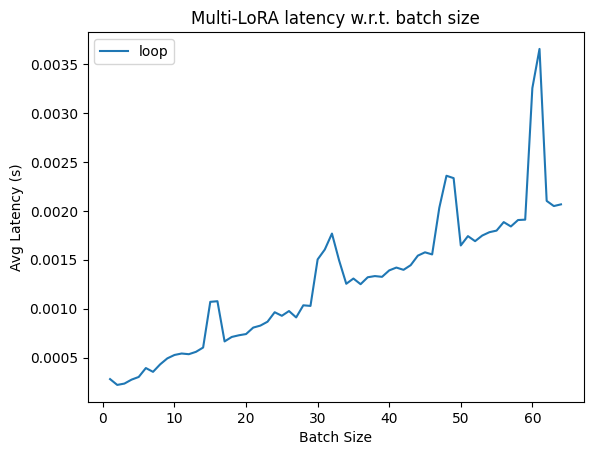

In [26]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

In [27]:
# define a lora interface.
class GatheredMultiLoraTestModel(torch.nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(10, hidden_size)
    self.linear = torch.nn.Linear(hidden_size, hidden_size)
    self.lm_head = torch.nn.Linear(hidden_size, 10)

  def forward(self, input_ids, adapts_a, adapts_b, lora_indicies):
    x = self.embedding(input_ids)
    x = self.linear_lora(x, adapts_a, adapts_b, lora_indicies)
    x = self.lm_head(x)
    return x

  def linear_lora(
      self,
      x: torch.Tensor,
      adapts_a: torch.Tensor,
      adapts_b: torch.Tensor,
      lora_indicies: torch.LongTensor
  ) -> torch.Tensor:
    y = self.linear(x)

    # gather the LoRA weights into a new tensor and apply
    lora_a = torch.index_select(adapts_a, 0, lora_indicies) # (batch_size, in_features, lora_rank)
    lora_b = torch.index_select(adapts_b, 0, lora_indicies) # (batch_size, lora_rank, out_features)
    y += x @ lora_a @ lora_b

    return y

model = GatheredMultiLoraTestModel(10)
model

GatheredMultiLoraTestModel(
  (embedding): Embedding(10, 10)
  (linear): Linear(in_features=10, out_features=10, bias=True)
  (lm_head): Linear(in_features=10, out_features=10, bias=True)
)

In [28]:
avg_latencies_gathered = benchmark(model)

1 0.0001467161178588867
2 0.00021549224853515626
3 0.00020315122604370117
4 0.0001791048049926758
5 0.000213623046875
6 0.0002046852111816406
7 0.00019886112213134764
8 0.00018658733367919923
9 0.00018877458572387696
10 0.0001921067237854004
11 0.00020198869705200195
12 0.0002332940101623535
13 0.0002046055793762207
14 0.00020876789093017577
15 0.00022508621215820313
16 0.0002265915870666504
17 0.0002394695281982422
18 0.00022921419143676758
19 0.00023681211471557616
20 0.0002813191413879395
21 0.00025452041625976564
22 0.00022683763504028321
23 0.00027445459365844726
24 0.00023681020736694336
25 0.0002648015022277832
26 0.000263343334197998
27 0.0002696809768676758
28 0.00028435850143432615
29 0.0007396688461303711
30 0.0005783982276916504
31 0.0003230056762695313
32 0.00030500078201293947
33 0.0006037340164184571
34 0.0006590976715087891
35 0.00030991458892822265
36 0.0003135237693786621
37 0.00031000137329101563
38 0.00031736135482788084
39 0.0002960677146911621
40 0.000350980281829

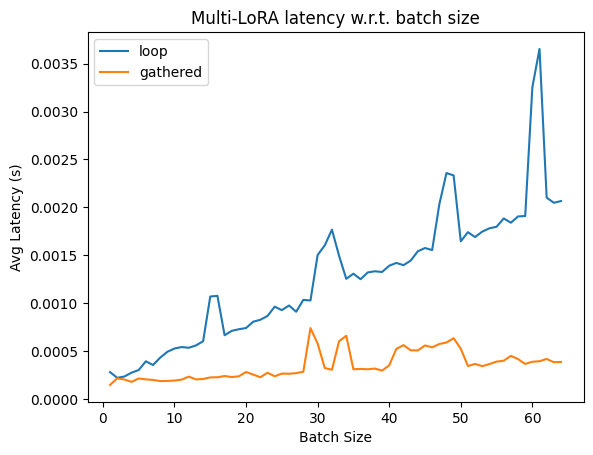

In [29]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()